In [1]:
!pip install pyspark
!pip install langdetect
!pip install pyspark_dist_explore
!pip install tweepy
!pip install textblob

     |████████████████████████████████| 204.2 MB 27 kB/s s eta 0:00:01     |██████████████████████████▎     | 167.4 MB 62.2 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 39.6 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=6a2626450da88676974ecd9fa17d124022461c9f8423f9fc1fa81168af999325
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
     |████████████████████████████████| 981 kB 1.3 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=281baa26a5dae378c4fcc4c5c518e8b92b084b6cd00e6c8c1288133782cd2887
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect


In [2]:
import os
import pandas as pd
import numpy as np

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.types import FloatType
from textblob import TextBlob
from langdetect import detect
import re

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [3]:
def langdetect1(tweet):
    try:
        if detect(tweet)=='en':
            return 1
        else:
            return 0
    except:
        return 0

def clean_tweet1(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
def sentiment_score1(tweet):
    return TextBlob(tweet).sentiment.polarity

def get_sentiment1(score): 
        if score > 0: 
            return 4
        elif score == 0: 
            return 2
        else: 
            return 0
        
@udf(returnType=IntegerType())
def langdetect(tweet):
    try:
        if detect(tweet)=='en':
            return 1
        else:
            return 0
    except:
        return 0
@udf(returnType=StringType())
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
@udf(returnType=FloatType())
def sentiment_score(tweet):
    return TextBlob(tweet).sentiment.polarity

@udf(returnType=IntegerType())
def get_sentiment(score): 
        if score > 0: 
            return 4
        elif score == 0: 
            return 2
        else: 
            return 0

In [12]:
start=time.time()

df1=pd.read_csv("../input/bitcoin-tweets-20160101-to-20190329/tweets.csv",sep=";",encoding='utf-8',nrows=10000)

df1=df1['text']
df1=pd.DataFrame(df1)
df1=df1.dropna()
df1['text'] = df1['text'].str.strip()
df1=df1[(df1.text!="")]

df1['englishornot']=df1['text'].map(langdetect1)
df1=df1[(df1.englishornot!=0)]
df1['cleantweet']=df1['text'].map(clean_tweet1)
df1['polarity']=df1['cleantweet'].map(sentiment_score1)
df1['output']=df1['polarity'].map(get_sentiment1)
print(df1.head())

end=time.time()

print("Total Execution Time in seconds = ",end-start) 

                                                text  englishornot  \
1  Cardano: Digitize Currencies; EOS https://t.co...             1   
2  Another Test tweet that wasn't caught in the s...             1   
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...             1   
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...             1   
6  @nwoodfine We have been building on the real #...             1   

                                          cleantweet  polarity  output  
1  Cardano Digitize Currencies EOS 6500 ROI AT am...       0.0       2  
2  Another Test tweet that wasn t caught in the s...       0.0       2  
3  Current Crypto Prices BTC 8721 99 USD ETH 266 ...       0.0       2  
4  Spiv Nosar Baz BITCOIN Is An Asset amp NOT A C...       0.0       2  
6  We have been building on the real bitcoin SV W...      -0.1       0  
Total Execution Time in seconds =  120.12887477874756


In [4]:
start=time.time()

spark = SparkSession.builder.master("local[10]").appName("Twitter-Sentiment-Analysis").getOrCreate()
df2=spark.read.csv(path="../input/bitcoin-tweets-20160101-to-20190329/tweets.csv",sep=";",header=True).limit(10000).cache()

df2 = df2.select('text')
df2 = df2.na.drop()
df2 = df2.withColumn('text', trim(col('text')))
df2 = df2.filter(col('text')!="")

df2=df2.withColumn("englishornot", langdetect(col("text")))
df2 = df2.filter(col('englishornot')!=0)
df2=df2.withColumn("cleantweet", clean_tweet(col("text")))
df2=df2.withColumn("polarity", sentiment_score(col("cleantweet")))
df2=df2.withColumn("output", get_sentiment(col("polarity")))

df2.show()

end=time.time()
print("Total Execution Time in seconds = ",end-start) 

+--------------------+------------+--------------------+------------+------+
|                text|englishornot|          cleantweet|    polarity|output|
+--------------------+------------+--------------------+------------+------+
|Cardano: Digitize...|           1|Cardano Digitize ...|         0.0|     2|
|Another Test twee...|           1|Another Test twee...|         0.0|     2|
|Current Crypto Pr...|           1|Current Crypto Pr...|         0.0|     2|
|Spiv (Nosar Baz):...|           1|Spiv Nosar Baz BI...|         0.0|     2|
|@nwoodfine We hav...|           1|We have been buil...|         0.2|     4|
|CHANGE IS COMING....|           1|CHANGE IS COMING ...|         0.2|     4|
|One of the useful...|           1|One of the useful...|         0.3|     4|
|BestMixer has bee...|           1|BestMixer has bee...|         0.0|     2|
|Invested my Life ...|           1|Invested my Life ...|         0.0|     2|
|Bitcoin Price Hit...|           1|Bitcoin Price Hit...|  0.14818181|     4|

In [11]:
start=time.time()

spark = SparkSession.builder.master("local[10]").appName("Twitter-Sentiment-Analysis").getOrCreate()
df=spark.read.csv(path="../input/bitcoin-tweets-20160101-to-20190329/tweets.csv",sep=";",header=True).cache()

df = df.select('text')
df = df.na.drop()
df = df.withColumn('text', trim(col('text')))
df = df.filter(col('text')!="")

df=df.withColumn("englishornot", langdetect(col("text")))
df = df.filter(col('englishornot')!=0)
df=df.withColumn("cleantweet", clean_tweet(col("text")))
df=df.withColumn("polarity", sentiment_score(col("cleantweet")))
df=df.withColumn("output", get_sentiment(col("polarity")))

df.show()

end=time.time()
print("Total Execution Time in seconds = ",end-start) 

+--------------------+------------+--------------------+------------+------+
|                text|englishornot|          cleantweet|    polarity|output|
+--------------------+------------+--------------------+------------+------+
|Cardano: Digitize...|           1|Cardano Digitize ...|         0.0|     2|
|Another Test twee...|           1|Another Test twee...|         0.0|     2|
|Current Crypto Pr...|           1|Current Crypto Pr...|         0.0|     2|
|Spiv (Nosar Baz):...|           1|Spiv Nosar Baz BI...|         0.0|     2|
|@nwoodfine We hav...|           1|We have been buil...|         0.2|     4|
|CHANGE IS COMING....|           1|CHANGE IS COMING ...|         0.2|     4|
|One of the useful...|           1|One of the useful...|         0.3|     4|
|BestMixer has bee...|           1|BestMixer has bee...|         0.0|     2|
|Invested my Life ...|           1|Invested my Life ...|         0.0|     2|
|Bitcoin Price Hit...|           1|Bitcoin Price Hit...|  0.14818181|     4|

In [10]:
output_count_df=df2.groupby('output').count()
output_count_df.show()

+------+-----+
|output|count|
+------+-----+
|     4|  940|
|     2| 1210|
|     0|  244|
+------+-----+



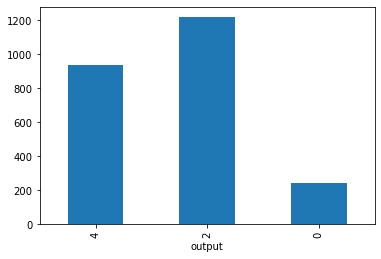

In [23]:
pandas_df=output_count_df.toPandas()
pandas_df=pandas_df.set_index('output')
pandas_df['count'].plot(kind="bar")